In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from pprint import pprint
from datetime import datetime
import dask_geopandas as dgpd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import KFold

from catboost import CatBoostRegressor, Pool, cv

from hyperopt import fmin, hp, tpe, STATUS_OK, STATUS_FAIL, Trials
import pickle
import warnings
from sklearn.metrics import r2_score

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Estimated Construction Costs for Housing

In [2]:
dbi = gpd.read_feather('../data/dbi_permits.geofeather')

In [5]:
homes = pd.read_excel('../data/Housing Production 2005-2022.xlsx')

In [6]:
costs = dbi[dbi.estimated_cost.notna() | dbi.revised_cost.notna()]
costs = costs.copy()

In [7]:
costs['cost'] = costs.revised_cost
costs['cost'] = costs['cost'].fillna(costs.estimated_cost)

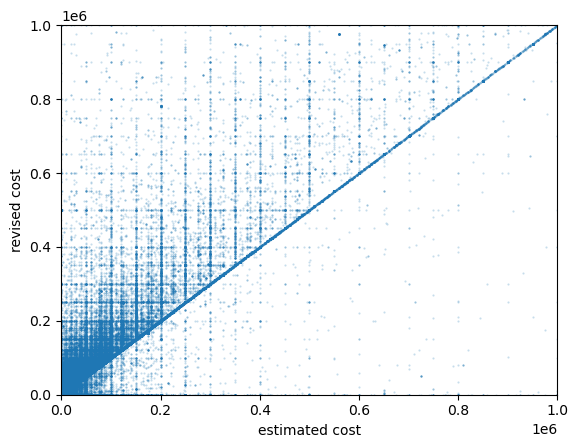

In [8]:
plt.scatter(dbi.estimated_cost, dbi.revised_cost, alpha=.25, s=.25)
plt.xlim((0, 1000000))
plt.ylim((0, 1000000))
plt.ylabel('revised cost')
plt.xlabel('estimated cost')
plt.show()

In [9]:
costs['new_units'] = costs['proposed_units'].fillna(0) - costs['existing_units'].fillna(0)

In [10]:
costs = costs.sort_values(['new_units'], ascending=False)

In [11]:
housing_costs = costs[costs.permit_number.isin(homes.BPA)]

In [12]:
housing_costs = housing_costs[housing_costs['completed_date'].notna()
                              & (housing_costs['new_units'] > 0)
                              & housing_costs['permit_type'].isin(('3','2','1'))]

In [13]:
housing_costs = housing_costs[housing_costs.permit_creation_date.dt.year > 2006]

In [14]:
housing_costs = housing_costs.sort_values('cost')

## Geospatial bluesky data

In [15]:
bluesky = gpd.read_feather('../geobluesky.geofeather')

In [16]:
bluesky = bluesky[bluesky['year'] >= 2007]

In [17]:
bluesky.year.max()

2016.0

In [18]:
bluesky.shape

(1530894, 19)

## Tax Data

In [19]:
tax = gpd.read_feather('../data/ef_df.geofeather')

In [20]:
tax.crs != bluesky.crs

True

In [21]:
tax.shape

(2031996, 46)

In [22]:
ddf = dgpd.from_geopandas(bluesky, npartitions=10)
ddf = ddf.to_crs(tax.crs)
bluesky = ddf.compute()

In [23]:
tax.closed_roll_year.min()

2007

In [24]:
df_list = []

for year in range(2007, 2017):
    parcels_year = bluesky[bluesky.year == year].copy()
    tax_year = tax[tax.closed_roll_year == year].copy()
    df_list.append(gpd.sjoin(parcels_year, tax_year, how='left', predicate='contains'))
    

In [25]:
panel_data = pd.concat(df_list)

In [26]:
panel_data.shape

(1912071, 65)

I first do a geospatial match, but when a one to many relationship is identified, i give priority to non-geospatial matching

In [32]:
panel_data['non_geo_match'] = panel_data['MapBlkLot_Master'].astype(str) == (panel_data.block + panel_data.lot).astype(str)

panel_data = panel_data.sort_values('non_geo_match', ascending=False)

In [33]:
panel_data = panel_data.drop_duplicates(['MapBlkLot_Master', 'year'])

In [34]:
panel_data.shape

(1530894, 66)

In [35]:
panel_data = panel_data.drop(columns=['index_right', 'non_geo_match'])

### Now to estimate housing costs given parcel and tax data

In [36]:
housing_costs = housing_costs[(housing_costs.cost / housing_costs.new_units) > 5000]

In [37]:
housing_costs_grouped = housing_costs.groupby(
    [
        'geometry', 
        'permit_creation_date'
    ]).agg({'cost': 'sum', 'new_units': 'sum'}).reset_index()

In [38]:
(housing_costs_grouped.cost / housing_costs_grouped.new_units).quantile(
    [0.01, 0.05, .1, .2, .3, .4, .5, .6, .7, .8, .9]
)

0.01     10000.000000
0.05     20000.000000
0.10     35000.000000
0.20     60000.000000
0.30     83333.333333
0.40    113841.509434
0.50    172052.961538
0.60    276245.210728
0.70    351250.000000
0.80    437902.400000
0.90    560152.000000
dtype: float64

In [39]:
housing_costs = gpd.GeoDataFrame(housing_costs_grouped, crs=dbi.crs)

In [40]:
housing_costs = housing_costs.to_crs(panel_data.crs)

## Specify year

In [41]:
df_list = []

for year in range(2007, 2017):
    parcels_year = panel_data[panel_data.year == year].copy()
    housing_costs_year = housing_costs[housing_costs.permit_creation_date.dt.year == year].copy()
    df_list.append(gpd.sjoin(parcels_year, housing_costs_year, how='left', predicate='contains'))

In [42]:
panel_costs_df = pd.concat(df_list)

In [43]:
panel_costs_df.cost.notna().sum()

1609

In [44]:
panel_costs_df = panel_costs_df.drop(columns= ['MapBlkLot_Master', 'mapblklot', 'geometry',
                     'index_right', 'closed_roll_year', 'lot', 'block',
                     'current_sales_date', 'property_location', 
                     'parcel_number', 'permit_creation_date'])

In [45]:
y = panel_costs_df['cost']

In [46]:
X = panel_costs_df.drop(columns=['cost', 'Zillow_Price_Real', 'Const_FedReserve_Real', 'new_units'])

In [47]:
X = X.replace({None: 'NaN', 'None': 'NaN', 'nan': 'NaN'})

In [48]:
trainX, testX, trainY = X.loc[y.notna()], X.loc[y.isna()], y[y.notna()]

In [49]:
trainY = np.log10(trainY)

### Catboost

In [51]:
cat_indices = np.where((trainX.dtypes == 'object') | (trainX.dtypes == 'category') | (trainX.dtypes == 'string'))[0]

In [52]:
train_pool = Pool(data=trainX, label=trainY, cat_features=cat_indices)

In [46]:
class PenalizeNegativePredictions:
    def calc_ders_range(self, approxes, targets, weights):
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)
        
        result = []
        for index in range(len(targets)):
            der1 = targets[index] - approxes[index]
            der2 = -1
            
            if approxes[index] < 0:
                der1 *= 1e3
                der2 *= 1e3
                
            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]
            
            result.append((der1, der2))
        
        return result

In [ ]:
def hyperopt_objective(params):
    cv_data = cv(
        params=params,
        pool=train_pool,
        fold_count=5,
        shuffle=True,
        partition_random_seed=0,
        stratified=False,
        logging_level='Silent',
        early_stopping_rounds=10
    )
    loss = cv_data['test-RMSE-mean'].min()
    return loss


# We initiate a Trial object to keep track of search results and we set a hyperparameter space
trials = Trials()
space = {
    "iterations": 1000,
    'learning_rate': hp.uniform('learning_rate', .02, .05),
    'depth': hp.randint('depth', 4, 10),
    'l2_leaf_reg': hp.loguniform('l2_leaf_reg', -5, 5),
    'border_count': hp.randint('border_count', 10, 255),
    'random_strength': hp.uniform('random_strength', 0, 2),
    'boosting_type': hp.choice('boosting_type', ['Ordered', 'Plain']),
    'loss_function': 'RMSE'
}

# We finally use fmin to perform the search
'''
best = fmin(hyperopt_objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            rstate=np.random.default_rng(0),
            trials=trials)
'''
print()

In [ ]:
best

In [53]:
best = {'boosting_type': 1,
 'border_count': 101,
 'depth': 7,
 'l2_leaf_reg': 0.4070893747529913,
 'learning_rate': 0.04108406392351036,
 'random_strength': 0.884308534942049}

In [54]:
best['boosting_type'] = 'Ordered' if best.get('boosting_type') == 0 else 'Plain'

In [55]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores = []

for train_index, test_index in kf.split(trainX):
    X_train_r, X_test_r = trainX.iloc[train_index], trainX.iloc[test_index]
    y_train_r, y_test_r = trainY.iloc[train_index], trainY.iloc[test_index]

    train_dataset_r = Pool(data=X_train_r, label=y_train_r,  cat_features=cat_indices)
    test_dataset_r = Pool(data=X_test_r, label=y_test_r,  cat_features=cat_indices)

    model_r = CatBoostRegressor(iterations=1000, loss_function='RMSE', random_seed=0, verbose=1, **best)
    model_r.fit(train_dataset_r, verbose=0)

    predictions_r = model_r.predict(test_dataset_r)
    r2 = r2_score(y_test_r, predictions_r)
    r2_scores.append(r2)
r2_scores

[0.7368879443961337,
 0.7554053730379106,
 0.7154450535036483,
 0.6897613581998825,
 0.7670064009623261]

In [56]:
sum(r2_scores) / 5

0.7329012260199802

In [ ]:
pickle.dump(trials, open("my_trials_construction.pkl", "wb"))

with open("my_trials_construction.pkl", "rb") as f:
    object = pickle.load(f)

df_trials = pd.DataFrame(object)
df_trials.to_csv(r'catboost_results_construction_costs.csv')

In [57]:
catboostFinal = CatBoostRegressor(**best, loss_function='RMSE', random_seed=0)

In [58]:
catboostFinal.fit(train_pool)

0:	learn: 0.8724074	total: 5.22ms	remaining: 5.22s
1:	learn: 0.8527172	total: 16.5ms	remaining: 8.24s
2:	learn: 0.8334782	total: 23.7ms	remaining: 7.87s
3:	learn: 0.8136507	total: 31.2ms	remaining: 7.77s
4:	learn: 0.7968545	total: 36.8ms	remaining: 7.32s
5:	learn: 0.7802332	total: 45.2ms	remaining: 7.48s
6:	learn: 0.7641225	total: 50.4ms	remaining: 7.15s
7:	learn: 0.7491506	total: 58.6ms	remaining: 7.27s
8:	learn: 0.7352448	total: 64.4ms	remaining: 7.09s
9:	learn: 0.7214391	total: 73.2ms	remaining: 7.25s
10:	learn: 0.7094425	total: 78.7ms	remaining: 7.07s
11:	learn: 0.6985236	total: 81.8ms	remaining: 6.73s
12:	learn: 0.6878860	total: 87ms	remaining: 6.61s
13:	learn: 0.6766207	total: 94.7ms	remaining: 6.67s
14:	learn: 0.6662691	total: 100ms	remaining: 6.58s
15:	learn: 0.6563007	total: 107ms	remaining: 6.61s
16:	learn: 0.6461655	total: 112ms	remaining: 6.5s
17:	learn: 0.6360329	total: 119ms	remaining: 6.52s
18:	learn: 0.6261023	total: 125ms	remaining: 6.44s
19:	learn: 0.6197657	total: 13

187:	learn: 0.3229813	total: 1.22s	remaining: 5.27s
188:	learn: 0.3225692	total: 1.23s	remaining: 5.26s
189:	learn: 0.3218189	total: 1.24s	remaining: 5.27s
190:	learn: 0.3209064	total: 1.25s	remaining: 5.28s
191:	learn: 0.3201493	total: 1.25s	remaining: 5.28s
192:	learn: 0.3198373	total: 1.26s	remaining: 5.27s
193:	learn: 0.3192884	total: 1.27s	remaining: 5.27s
194:	learn: 0.3184693	total: 1.27s	remaining: 5.26s
195:	learn: 0.3180485	total: 1.28s	remaining: 5.27s
196:	learn: 0.3169443	total: 1.29s	remaining: 5.26s
197:	learn: 0.3163997	total: 1.3s	remaining: 5.26s
198:	learn: 0.3155116	total: 1.3s	remaining: 5.24s
199:	learn: 0.3144896	total: 1.31s	remaining: 5.24s
200:	learn: 0.3139614	total: 1.31s	remaining: 5.22s
201:	learn: 0.3137959	total: 1.32s	remaining: 5.22s
202:	learn: 0.3135887	total: 1.33s	remaining: 5.21s
203:	learn: 0.3130780	total: 1.34s	remaining: 5.21s
204:	learn: 0.3122911	total: 1.34s	remaining: 5.2s
205:	learn: 0.3116844	total: 1.35s	remaining: 5.2s
206:	learn: 0.31

371:	learn: 0.2442917	total: 2.44s	remaining: 4.13s
372:	learn: 0.2441038	total: 2.45s	remaining: 4.12s
373:	learn: 0.2437995	total: 2.46s	remaining: 4.12s
374:	learn: 0.2432386	total: 2.46s	remaining: 4.11s
375:	learn: 0.2427958	total: 2.47s	remaining: 4.1s
376:	learn: 0.2426814	total: 2.48s	remaining: 4.09s
377:	learn: 0.2423830	total: 2.48s	remaining: 4.09s
378:	learn: 0.2420377	total: 2.49s	remaining: 4.08s
379:	learn: 0.2419086	total: 2.5s	remaining: 4.08s
380:	learn: 0.2416604	total: 2.5s	remaining: 4.07s
381:	learn: 0.2414411	total: 2.51s	remaining: 4.06s
382:	learn: 0.2413044	total: 2.52s	remaining: 4.06s
383:	learn: 0.2410129	total: 2.53s	remaining: 4.05s
384:	learn: 0.2406439	total: 2.53s	remaining: 4.04s
385:	learn: 0.2403414	total: 2.54s	remaining: 4.04s
386:	learn: 0.2399353	total: 2.54s	remaining: 4.03s
387:	learn: 0.2391897	total: 2.55s	remaining: 4.03s
388:	learn: 0.2390193	total: 2.56s	remaining: 4.02s
389:	learn: 0.2387390	total: 2.56s	remaining: 4.01s
390:	learn: 0.2

556:	learn: 0.1918687	total: 3.65s	remaining: 2.9s
557:	learn: 0.1916789	total: 3.66s	remaining: 2.9s
558:	learn: 0.1913925	total: 3.67s	remaining: 2.89s
559:	learn: 0.1911948	total: 3.67s	remaining: 2.88s
560:	learn: 0.1909973	total: 3.68s	remaining: 2.88s
561:	learn: 0.1909474	total: 3.68s	remaining: 2.87s
562:	learn: 0.1907004	total: 3.69s	remaining: 2.87s
563:	learn: 0.1905234	total: 3.7s	remaining: 2.86s
564:	learn: 0.1902745	total: 3.7s	remaining: 2.85s
565:	learn: 0.1900816	total: 3.71s	remaining: 2.84s
566:	learn: 0.1899139	total: 3.72s	remaining: 2.84s
567:	learn: 0.1897549	total: 3.72s	remaining: 2.83s
568:	learn: 0.1896077	total: 3.73s	remaining: 2.83s
569:	learn: 0.1894650	total: 3.73s	remaining: 2.82s
570:	learn: 0.1893210	total: 3.74s	remaining: 2.81s
571:	learn: 0.1891792	total: 3.75s	remaining: 2.81s
572:	learn: 0.1888890	total: 3.76s	remaining: 2.8s
573:	learn: 0.1884514	total: 3.76s	remaining: 2.79s
574:	learn: 0.1882275	total: 3.77s	remaining: 2.79s
575:	learn: 0.187

743:	learn: 0.1565038	total: 4.86s	remaining: 1.67s
744:	learn: 0.1564386	total: 4.86s	remaining: 1.66s
745:	learn: 0.1562944	total: 4.87s	remaining: 1.66s
746:	learn: 0.1560722	total: 4.88s	remaining: 1.65s
747:	learn: 0.1558838	total: 4.88s	remaining: 1.65s
748:	learn: 0.1556246	total: 4.89s	remaining: 1.64s
749:	learn: 0.1554564	total: 4.9s	remaining: 1.63s
750:	learn: 0.1553675	total: 4.9s	remaining: 1.63s
751:	learn: 0.1551690	total: 4.91s	remaining: 1.62s
752:	learn: 0.1549915	total: 4.92s	remaining: 1.61s
753:	learn: 0.1549003	total: 4.92s	remaining: 1.61s
754:	learn: 0.1545169	total: 4.93s	remaining: 1.6s
755:	learn: 0.1544098	total: 4.94s	remaining: 1.59s
756:	learn: 0.1542058	total: 4.94s	remaining: 1.59s
757:	learn: 0.1539875	total: 4.95s	remaining: 1.58s
758:	learn: 0.1538237	total: 4.95s	remaining: 1.57s
759:	learn: 0.1536878	total: 4.96s	remaining: 1.57s
760:	learn: 0.1535797	total: 4.97s	remaining: 1.56s
761:	learn: 0.1535360	total: 4.97s	remaining: 1.55s
762:	learn: 0.1

930:	learn: 0.1286134	total: 6.08s	remaining: 450ms
931:	learn: 0.1284338	total: 6.08s	remaining: 444ms
932:	learn: 0.1283367	total: 6.09s	remaining: 437ms
933:	learn: 0.1282417	total: 6.09s	remaining: 431ms
934:	learn: 0.1281215	total: 6.1s	remaining: 424ms
935:	learn: 0.1279742	total: 6.11s	remaining: 418ms
936:	learn: 0.1279150	total: 6.11s	remaining: 411ms
937:	learn: 0.1277142	total: 6.12s	remaining: 405ms
938:	learn: 0.1276666	total: 6.13s	remaining: 398ms
939:	learn: 0.1275552	total: 6.13s	remaining: 392ms
940:	learn: 0.1273918	total: 6.14s	remaining: 385ms
941:	learn: 0.1272955	total: 6.15s	remaining: 379ms
942:	learn: 0.1271232	total: 6.16s	remaining: 372ms
943:	learn: 0.1269261	total: 6.16s	remaining: 366ms
944:	learn: 0.1266638	total: 6.17s	remaining: 359ms
945:	learn: 0.1265769	total: 6.17s	remaining: 352ms
946:	learn: 0.1264339	total: 6.18s	remaining: 346ms
947:	learn: 0.1262132	total: 6.19s	remaining: 339ms
948:	learn: 0.1261216	total: 6.2s	remaining: 333ms
949:	learn: 0.

In [59]:
predictions = catboostFinal.predict(testX)

In [60]:
(predictions < 0).mean()

0.0

In [61]:
panel_data['construction_cost_est'] = 0
panel_data.loc[X.loc[y.isna()].index, 'construction_cost_est'] = 10 ** predictions
panel_data.loc[X.loc[y.notna()].index, 'construction_cost_est'] = 10 ** trainY

In [62]:
panel_data['construction_cost_est'].describe()

count    1.530894e+06
mean     8.847597e+05
std      4.826720e+06
min      4.401363e+03
25%      8.491887e+04
50%      1.421439e+05
75%      2.527125e+05
max      8.000000e+08
Name: construction_cost_est, dtype: float64

In [63]:
panel_costs_df['cost'].describe()

count    1.609000e+03
mean     6.565093e+06
std      2.796878e+07
min      6.000000e+03
25%      1.313100e+05
50%      4.984850e+05
75%      1.500000e+06
max      8.000000e+08
Name: cost, dtype: float64

In [64]:
panel_data.to_feather('../data/panel_data_estimated_costs.geofeather')

### ExtraTreesRegressor

In [ ]:
X_dummy = pd.get_dummies(X, drop_first=True, dummy_na=True)

In [ ]:
trainX_dummy, testX_dummy = X_dummy[y.notna()], X_dummy[y.isna()]

In [ ]:
trainX_dummy = trainX_dummy.fillna(-9999)

In [ ]:
regression = Pipeline([('rf',
                        ExtraTreesRegressor(n_estimators=100, random_state=0, 
                                            max_samples=1000, n_jobs=-1, bootstrap=True))])
rf_param_grid = [
    {
        'rf__max_depth': stats.randint(5, 35),
        'rf__ccp_alpha': stats.loguniform(1e-14, 1e-7),
        'rf__max_features': stats.uniform(.98, .02),
        'rf__max_samples': stats.randint(900, int(trainY.shape[0]*.8))
    }
]

In [ ]:
rs = RandomizedSearchCV(regression, rf_param_grid, n_iter=10, random_state=0, verbose=1, cv=5)

rs.fit(trainX_dummy, trainY)

In [ ]:
def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df[:10]

    plt.figure(figsize=(10,8))
    plt.barh(fi_df['feature_names'], fi_df['feature_importance'], align='center')
    plt.xlabel('Importance')
    plt.title(model_type + ' - Feature Importance')
    plt.show()

plot_feature_importance(rs.best_estimator_['rf'].feature_importances_, trainX_dummy.columns, 'Random Forest')

In [ ]:
param_search_results = pd.DataFrame(rs.cv_results_['params'])
param_search_results['score'] = rs.cv_results_['mean_test_score']
param_search_results = param_search_results.sort_values('score', ascending=False)
param_search_results

In [ ]:
predY = 10 ** rs.predict(testX_dummy)

In [ ]:
plt.plot(pd.DataFrame({'year': testX_dummy['year'], 'cost': predY}).groupby('year').agg({'cost': 'mean'}))

In [ ]:
trainY.min()

In [ ]:
PartialDependenceDisplay.from_estimator(
    rs, 
    testX_dummy.sample(100, random_state=123), 
    ['year'], 
    kind='both')



In [ ]:
known_construction = pd.read_csv('../data/efz/construction.csv', skiprows=1, sep=' ', on_bad_lines='skip')

In [ ]:
plt.plot(known_construction[(known_construction['YEAR'] > 2006) & 
                            (known_construction['YEAR'] < 2017)].groupby('YEAR')['BCI'].mean())